Shape of USA data: (2596, 14)
Shape after filtering invalid codes (USA): (2428, 14)
Shape of df_model after dropping NaNs: (2428, 14)

Classification Report (Random Forest):

              precision    recall  f1-score   support

           1       0.35      0.18      0.24        33
           2       0.41      0.43      0.42       111
           3       0.45      0.49      0.47       186
           4       0.52      0.49      0.51       156

    accuracy                           0.46       486
   macro avg       0.43      0.40      0.41       486
weighted avg       0.46      0.46      0.45       486

Confusion Matrix:
 [[ 6 16  7  4]
 [ 6 48 44 13]
 [ 4 37 91 54]
 [ 1 16 62 77]]


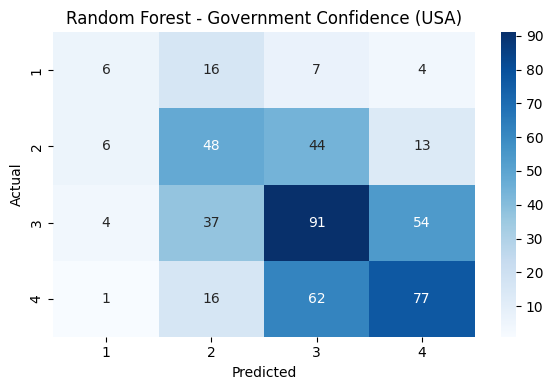

age            : 0.2343
income_scale   : 0.1364
educ_level     : 0.1137
demo_import    : 0.0943
elect_conf     : 0.0830
police_conf    : 0.0713
armed_conf     : 0.0694
courts_conf    : 0.0682
civil_conf     : 0.0680
party_conf     : 0.0613


In [1]:
###############################################################################
# 1. IMPORTS
###############################################################################

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

###############################################################################
# 2. LOAD CSV & FILTER G8
###############################################################################

wave7_csv = "data/preprocessed/filtered_wave_7.csv"  # <-- Adjust if needed
df = pd.read_csv(wave7_csv, low_memory=False)

g8_codes = [840, 124, 250, 276, 380, 392, 643, 826]
df_g8 = df[df["Country"].isin(g8_codes)].copy()

###############################################################################
# 3. FOCUS ON USA ONLY (COUNTRY CODE 840)
###############################################################################

df_usa = df_g8[df_g8["Country"] == 840].copy()
print("Shape of USA data:", df_usa.shape)

###############################################################################
# 4. FILTER OUT INVALID RESPONSES
#    Confidence: 1..4 valid; Importance of democracy: 1..10
#    Education (example 0..8), Income (1..10), Age > 0
###############################################################################

valid_conf = [1, 2, 3, 4]
valid_demo = list(range(1, 11))
valid_educ = list(range(0, 9))
valid_income = list(range(1, 11))

df_clean = df_usa[
    df_usa["C Government"].isin(valid_conf) &
    df_usa["C Elections"].isin(valid_conf) &
    df_usa["C Political parties"].isin(valid_conf) &
    df_usa["C Police"].isin(valid_conf) &
    df_usa["C Courts"].isin(valid_conf) &
    df_usa["C Armed forces"].isin(valid_conf) &
    df_usa["C Civil services"].isin(valid_conf) &
    df_usa["Importance of democracy"].isin(valid_demo) &
    df_usa["Highest educational level"].isin(valid_educ) &
    df_usa["Scale of incomes"].isin(valid_income) &
    (df_usa["Age"] > 0)
].copy()

print("Shape after filtering invalid codes (USA):", df_clean.shape)

###############################################################################
# 5. RENAME COLUMNS FOR CONVENIENCE
###############################################################################

df_clean = df_clean.rename(columns={
    "C Government": "gov_conf",
    "C Elections": "elect_conf",
    "C Political parties": "party_conf",
    "C Police": "police_conf",
    "C Courts": "courts_conf",
    "C Armed forces": "armed_conf",
    "C Civil services": "civil_conf",
    "Importance of democracy": "demo_import",
    "Highest educational level": "educ_level",
    "Scale of incomes": "income_scale",
    "Age": "age"
})

###############################################################################
# 6. PREPARE DATA FOR RANDOM FOREST CLASSIFIER
#    Target = gov_conf (1..4)
#    Predictors = add any of the renamed columns you want to include
###############################################################################

predictors = [
    "elect_conf", "party_conf", "police_conf", "courts_conf",
    "armed_conf", "civil_conf", "demo_import", "educ_level",
    "income_scale", "age"
]

df_model = df_clean.dropna(subset=["gov_conf"] + predictors)
X = df_model[predictors]
y = df_model["gov_conf"]

print("Shape of df_model after dropping NaNs:", df_model.shape)

###############################################################################
# 7. SPLIT DATA INTO TRAIN / TEST
###############################################################################

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

###############################################################################
# 8. FIT RANDOM FOREST
###############################################################################

rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    random_state=42
)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

###############################################################################
# 9. EVALUATE MODEL PERFORMANCE
###############################################################################

print("\nClassification Report (Random Forest):\n")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

###############################################################################
# 10. PLOT CONFUSION MATRIX
###############################################################################

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=[1,2,3,4],
            yticklabels=[1,2,3,4])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Random Forest - Government Confidence (USA)")
plt.tight_layout()
plt.show()

###############################################################################
# 11. (OPTIONAL) FEATURE IMPORTANCES
###############################################################################

feat_importances = rf.feature_importances_
for name, val in sorted(zip(predictors, feat_importances), key=lambda x: x[1], reverse=True):
    print(f"{name:15s}: {val:.4f}")
